In [9]:
import numpy as np 
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
import pandas as pnd
from scipy import interpolate
from scipy.integrate import odeint
matplotlib.rcParams.update({'font.size': 14})
from osgeo import ogr, osr,gdal
#sys.path.append(r"r:\PythonSource")
#sys.path.append(r"r:\Climate\software\python")
#import raster_helper as rstrh

## shape file to raster

### function

In [61]:
def burnShapeFileToRaster(burnValue,rasterDrawAtrib,ShapeFileName,SrcRasterFileName,DestRasterFileName,
                          initRasterBy=None,initNoDataValueBy=None,raster_type =gdal.GDT_Float32 ,raster_options=['COMPRESS=LZW']):
    # Open the dataset from the file
    dataset = ogr.Open(ShapeFileName)
    # Make sure the dataset exists -- it would be None if we couldn't open it
    if not dataset:
        print('Error: could not open dataset')
    layer_count = dataset.GetLayerCount()
    print('The shapefile has {n} layer(s)\n'.format(n=layer_count))

    ### What is the name of the 1 layer?
    layer = dataset.GetLayerByIndex(0)
    out_raster_ds = None
    if SrcRasterFileName!=DestRasterFileName:
        raster_ds = gdal.Open(SrcRasterFileName, gdal.GA_ReadOnly)
        ncol,nrow = raster_ds.RasterXSize,raster_ds.RasterYSize
        proj = raster_ds.GetProjectionRef()
        ext = raster_ds.GetGeoTransform()
        raster_ds = None
        memory_driver = gdal.GetDriverByName('GTiff')
        out_raster_ds = memory_driver.Create(DestRasterFileName, ncol, nrow, 1, raster_type, options=raster_options)
        if proj is not None:
            out_raster_ds.SetProjection(proj)
        else:
            sr = osr.SpatialReference()
            sr.ImportFromEPSG(3301)
            sr_wkt = sr.ExportToWkt()
            out_raster_ds.SetProjection(sr_wkt)
            print(sr_wkt)
        if ext is not None:
            out_raster_ds.SetGeoTransform(ext)
    else:
        out_raster_ds = gdal.Open(DestRasterFileName, gdal.GA_Update)

    b = out_raster_ds.GetRasterBand(1)
    if initRasterBy is not None:
        b.Fill(initRasterBy)
    if initNoDataValueBy is not None:
        b.SetNoDataValue(initNoDataValueBy)
    # Rasterize the shapefile layer to our new dataset
    status = gdal.RasterizeLayer(out_raster_ds,  # output to our new dataset
                                 [1],  # output to our new dataset's first band
                                 layer,  # rasterize this layer
                                 None, None,  # don't worry about transformations since we're in same projection
                                 burnValue,  # burn value 0
                                 rasterDrawAtrib
                                 )
    # Close dataset
    out_raster_ds = None

    if status != 0:
        print("error!")
    else:
        print("Success")

### Create raster mask

In [62]:
SrcRasterFileName = r'c:\Calculations\Ledaji\Example\gol_aster1.tif'
DestRasterFileName = r'c:\Calculations\Ledaji\Example\mask.tif'
ShapeFileName = r"c:\Calculations\Ledaji\Example\2015_Gol_Shapefile_32642.shp"
initRasterBy = 9999
initNoDataValueBy = 9999
burnValue = [1]
raster_type = gdal.GDT_Int16
raster_options = ['COMPRESS=LZW']# "COMPRESS=DEFLATE" "PREDICTOR=2"
rasterDrawAtrib = ['ALL_TOUCHED=TRUE',  # rasterize all pixels touched by polygons
                   'ATTRIBUTE=id']      # put raster values according to the 'id' field values
rasterDrawAtrib = ['ALL_TOUCHED=TRUE']
burnShapeFileToRaster(burnValue,rasterDrawAtrib,
                                    ShapeFileName,SrcRasterFileName,DestRasterFileName,
                                    initRasterBy,initNoDataValueBy,raster_type ,raster_options)

The shapefile has 1 layer(s)

Success


## read rasters

### Qgis => make slope raster

### Load rasters

In [13]:
raster = gdal.Open(r"c:\Calculations\Ledaji\Example\gol_aster1.tif", gdal.GA_ReadOnly)
banddataraster = raster.GetRasterBand(1)
no_data_val = banddataraster.GetNoDataValue()
z0 = banddataraster.ReadAsArray(0, 0, raster.RasterXSize, raster.RasterYSize).astype(np.float32)
raster = None

In [14]:
raster = gdal.Open(r"c:\Calculations\Ledaji\Example\Gol_slope.tif", gdal.GA_ReadOnly)
banddataraster = raster.GetRasterBand(1)
no_data_val = banddataraster.GetNoDataValue()
slope = banddataraster.ReadAsArray(0, 0, raster.RasterXSize, raster.RasterYSize).astype(np.float32)
raster = None

In [66]:
raster = gdal.Open(r"c:\Calculations\Ledaji\Example\mask.tif", gdal.GA_ReadOnly)
banddataraster = raster.GetRasterBand(1)
no_data_val = banddataraster.GetNoDataValue()
#xOrigin, pixelWidth, a, yOrigin, aa, pixelHeight 
#transfZ= raster.GetGeoTransform()
mask = banddataraster.ReadAsArray(0, 0, raster.RasterXSize, raster.RasterYSize).astype(np.int16)
mask = mask==1
raster = None

$H_{max}=\frac{\tau}{sin(\alpha)\rho g}$

In [84]:
tau,rho,g = 1E5, 900.0, 9.8 
area = 5491572 #m^2
minSlope,maxSlope =5, 70
Hmax = 1E5/(np.radians(np.clip(slope,minSlope,maxSlope))*rho*g)
Hmax[~mask]=0

In [88]:
zL = np.array(z0)
zL[mask] -= Hmax[mask]

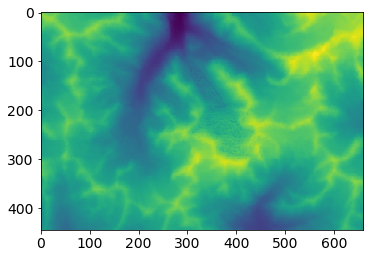

In [89]:
plt.imshow(zL)